# 主成分分析PCA: 降低維度
```
1. 我們輸入的資料, sklearn都用矩陣表示, 所以可以用使用SVD奇異質分解, 線性代數的做法, 對應到幾何意義就是降維度 
   => 知其然不知其所以然
2. M = USV
    M: mxn, 
    S: mxm(正交矩陣)
    D: mxn(部分對角矩陣)
    V: nxn(正交矩陣)
    U *= S[:{我們設定的降維維度}] => 
        https://zh.wikipedia.org/wiki/%E5%A5%87%E5%BC%82%E5%80%BC%E5%88%86%E8%A7%A3(維基百科有例子可看)
3. 文章分類的feature就是詞, 我想降維度這裡不太適合用PCA, 因為extract關鍵字, 都有額外的方法論了(TF-IDF, Text Rank等等...)
   PCA降維度是extract主要維度沒錯, 但是畢竟是黑盒子(絕對不是簡單的拔掉幾個dimension...), 我想他應該沒有厲害到可以勝過那些方法論

參考資料: https://ljalphabeta.gitbooks.io/python-/content/pca.html
         http://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
         https://zh.wikipedia.org/wiki/%E5%A5%87%E5%BC%82%E5%80%BC%E5%88%86%E8%A7%A3
```

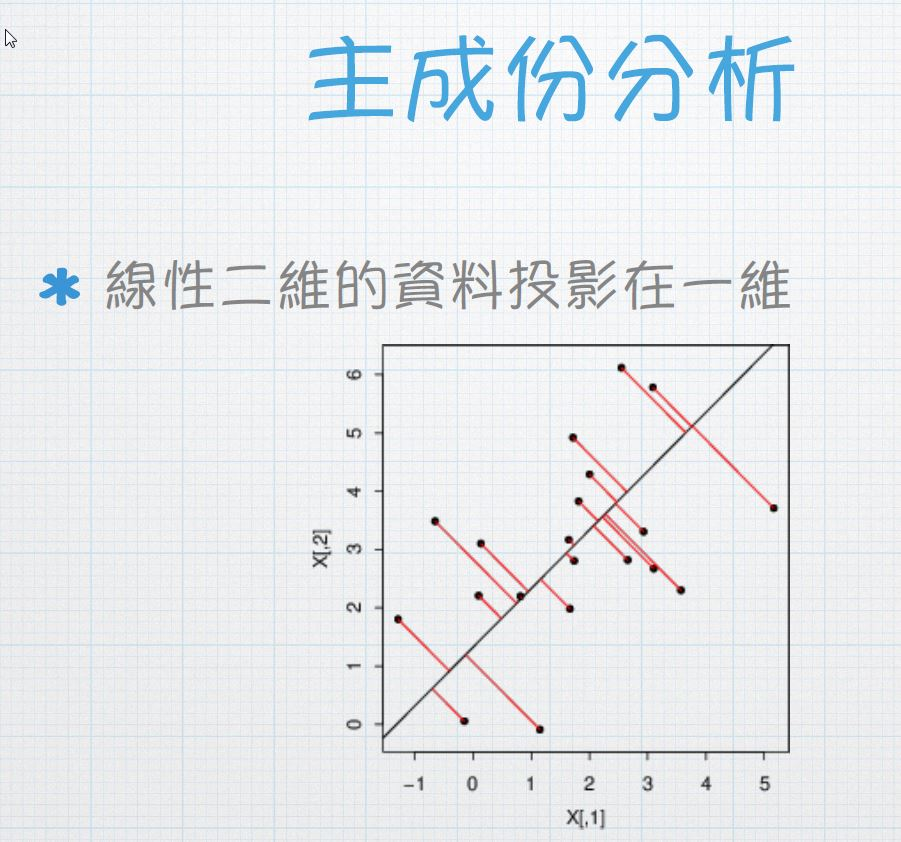

In [1]:
# 借用木刻思的圖片
from IPython.display import Image
Image('pca.jpg')

In [24]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# 抓出頻果新聞資料
apple36Df, apple78Df = None, None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
    
    apple36Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160301_20160630_02
         order by batchno
    ''', sklearnConn)
apple36Df.head()

,forum,subject,term,keyword,content,pageurl
0,strange,農婦打噴嚏燒傷8頭驢 20萬飛了,山東 劉姓 農婦 打火機 編號 掛牌 噴嚏 倒楣 驢子 燒傷 人民幣 台幣 中國 齊魯 報導...,驢子 驢子 驢子 驢子 驢子 驢子 驢子 農婦 農婦 農婦 農婦 噴嚏 噴嚏 噴嚏 紋身 紋...,山東一名劉姓農婦，日前在用打火機替家中飼養的毛驢掛上編號掛牌時，忍不住打了個噴嚏，沒想到手一...,http://www.appledaily.com.tw/realtimenews/arti...
1,strange,最新款007座駕 日內瓦展前曝光,形象 英國 martin 旗下 十二 跑車 消息 國外 媒體 瑞士 時間 日內瓦 車展 推出...,車展 車展 新款 新款 優雅 優雅 力表 過動 渦輪引擎 曝光 曝光 渦輪 元則 端倪 ma...,形象與007專屬座駕密不可分的英國Aston Martin，旗下行之有年的DB9十二缸跑車，...,http://www.appledaily.com.tw/realtimenews/arti...
2,strange,上班族好無奈 最怕同事這些壞習慣,職場 同事 百款 上班族 星期 同事 時間 小時 小心 衛生習慣 公德心 習慣 同事 報導 ...,冰箱 冰箱 冰箱 同事 同事 同事 生氣 生氣 衛生習慣 百款 大吼大叫 易怒 公德心 公用...,職場同事百百款，身為一位上班族，一星期有5天必須跟同事見面，每天相處時間還得要8小時以上，如...,http://www.appledaily.com.tw/realtimenews/arti...
3,strange,【占卜】你為什麼想分手？,單身 相愛 分手 原因 家庭 壓力 第三者 金錢 工作 老師 數字 占卜 分手 原因 楊婷 ...,分手 分手 分手 分手 愛情 愛情 愛情 相愛 相愛 資料 資料 資料 資料 照片 照片 照...,你恢復單身了嗎？相愛容易相處難，會讓你想分手的原因是什麼呢？是家庭壓力、第三者、金錢還是工作...,http://www.appledaily.com.tw/realtimenews/arti...
4,strange,【旅途中】櫻花叢中的小精靈,櫻花 季節 發現 櫻花 雙活 眼睛 棲蘭 武陵農場 意外 漂亮 實在 可愛 小精靈 棲蘭 國...,棲蘭 棲蘭 櫻花 櫻花 櫻花 畫眉 畫眉 武陵農場 武陵農場 賞櫻 賞櫻 親子 親子 雙活 ...,春暖花開，又到了追櫻花的季節，有沒有發現粉嫩粉嫩的櫻花，幾雙活靈活現的的眼睛在盯著呢？愛玩姐...,http://www.appledaily.com.tw/realtimenews/arti...


In [6]:
# 用PCA降為度會用掉很大的資源, 這裡原本要用SGDClassifier去降維度後當作訓練資料, 可是一樣是Memry error
# 所以就此打住
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA

vec = TfidfVectorizer()
termMx = vec.fit_transform(apple36Df.term)
pca = PCA(20)
dcpTermMx = pca.fit_transform(termMx.toarray())

MemoryError: 

In [19]:
irisDf = pd.DataFrame(columns=iris.feature_names, data=iris.data)
irisDf['target_names'] = iris.target_names[iris.target]
irisDf

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_names
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


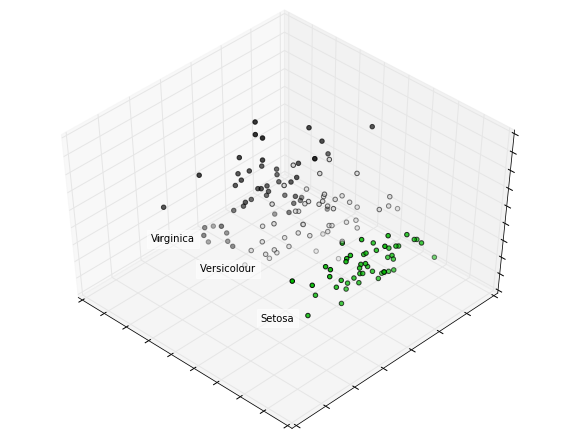

In [21]:
# 官網鳶尾花資料降維度的範例, 目前還有點看不懂..., 之後會找時間理解~

# Code source: Gaël Varoquaux
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

# Kernel PCA 降維
```
1. 非線性的將低維度, 跟SVM一樣可使用Kernel函數RBF來作維度映射
2. 官網說明:  Kernel PCA is able to find a projection of the data that makes data linearly separable, 看圖的左下角
   所以對於高維度的資料降為給分類器用應該是很有用的~
```

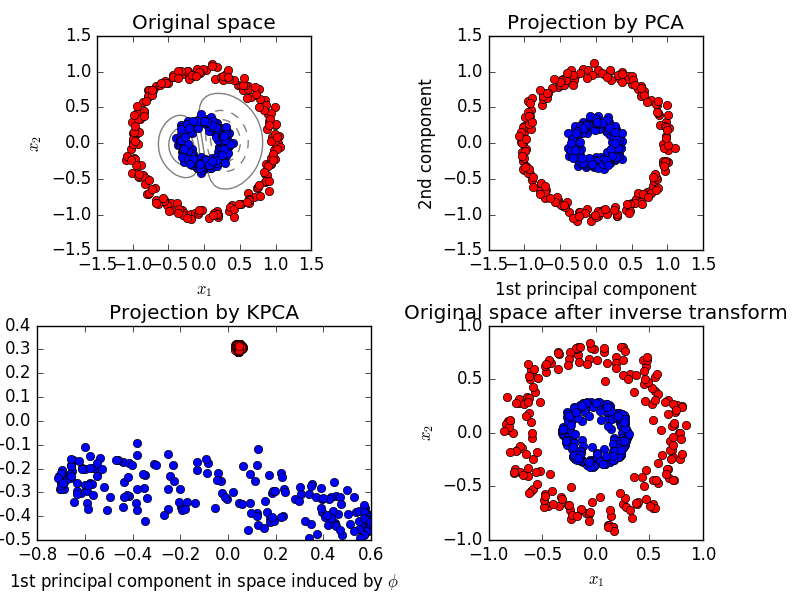

In [20]:
from IPython.display import Image
Image('kernel_pca.png')

In [1]:
print(__doc__)

# Authors: Mathieu Blondel
#          Andreas Mueller
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.plot(X[reds, 0], X[reds, 1], "ro")
plt.plot(X[blues, 0], X[blues, 1], "bo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.plot(X_pca[reds, 0], X_pca[reds, 1], "ro")
plt.plot(X_pca[blues, 0], X_pca[blues, 1], "bo")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.plot(X_kpca[reds, 0], X_kpca[reds, 1], "ro")
plt.plot(X_kpca[blues, 0], X_kpca[blues, 1], "bo")
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.plot(X_back[reds, 0], X_back[reds, 1], "ro")
plt.plot(X_back[blues, 0], X_back[blues, 1], "bo")
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

Automatically created module for IPython interactive environment


D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\matplotlib\ticker.py:1416: RuntimeWarning: invalid value encountered in double_scalars
  best_vmin = step * divmod(vmin, step)[0]
D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\matplotlib\ticker.py:1421: RuntimeWarning: invalid value encountered in double_scalars
  extra_bins = int(divmod((best_vmax - vmax), step)[0])


ValueError: cannot convert float NaN to integer

In [2]:
X, y = make_circles(n_samples=400, factor=.3, noise=.05)
X

array([[-1.02303689, -0.14903685],
       [ 0.24137323,  0.99796924],
       [ 0.7972233 ,  0.65331824],
       [ 0.50349407, -0.84930196],
       [ 0.31561231,  0.94153257],
       [ 0.27350601, -0.17074847],
       [-0.99930891, -0.26543547],
       [ 0.1775844 , -0.96216272],
       [ 0.20165597,  0.14220549],
       [-0.299616  ,  0.31088508],
       [-0.95923794,  0.3457013 ],
       [-0.16204631, -0.31840217],
       [ 0.29152789, -0.84988292],
       [ 0.6130546 , -0.79105454],
       [-0.20685851, -0.15926802],
       [ 0.22649466,  0.05851627],
       [-0.0130477 , -0.21504868],
       [ 0.37853712, -0.00362049],
       [-0.89662561, -0.36977386],
       [-0.13339482, -0.35777284],
       [ 0.82512066,  0.48104091],
       [-0.28324689, -0.98850874],
       [-0.95116816,  0.05681415],
       [-0.32586124,  0.02363726],
       [-0.09917015, -1.01899387],
       [ 0.04256021,  0.37644936],
       [-0.97291032,  0.01967717],
       [ 0.73700169,  0.63691486],
       [ 0.37673261,